# Determining Sentiment
Reused -> https://srome.github.io/Dont-Solve-Simulate-Markov-Chain-Monte-Carlo-Methods-with-PyMC3/

This example is admittedly a lot more complicated than the previous example. The model presented below is inspired by Simon Jackman’s paper “Pooling the Polls Over an Election Campaign”. The focus of the model is tracking the determination of how many people will vote for a certain candidate (or support an issue, etc) over time.

Generating Data
We are going to generate data for this experiment. First, we will generate the true sentiment towards an issue (i.e. the % of the population for it) using a Gaussian Random Walk up to time T. We will call the true sentiment S.
St∼N(αt−1,.022), t=2,…,T
α1=.53
To generate fake polls, let ωi be the margin of error for pollster i, then we simulate their polls pi,t, the % polled that agree with the issue, via
pi,t∼Normal(St,ωi), t=1,…,T.

In [1]:
import numpy as np
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Create fluctuating poll data for four pollsters
starting_sentiment = .53
true_sentiment = starting_sentiment + np.random.normal(0,.02,size=100).cumsum()
margin_of_error_poll_1 = .02
margin_of_error_poll_2 = .01
margin_of_error_poll_3 = .04
margin_of_error_poll_4 = .05
poll_data = [ np.random.normal(true_sentiment, margin_of_error_poll_1, size=100),
            np.random.normal(true_sentiment, margin_of_error_poll_2,size=100),
            np.random.normal(true_sentiment, margin_of_error_poll_3,
                                              size=100),
            np.random.normal(true_sentiment, margin_of_error_poll_4,
                                              size=100)]

In [4]:
# Creating the proper indices to assign variables to the correct polls
polling_ind = np.zeros((4,100))
polling_ind[1] = np.ones(100)
polling_ind[2] = np.ones(100)*2
polling_ind[3] = np.ones(100)*3
polling_ind = polling_ind.astype(int)


with pm.Model() as poll_model:
    #Prior for starting point
    prior = pm.Normal('p', mu=.55, sd=.3)

    # Random walk and hyperprior
    sigma = pm.Exponential('sigma', 1./.2, testval=.1) # No more than 20% avg
    s = pm.GaussianRandomWalk('s', sd=sigma**-2, shape=100)

    # Margin of error prior
    sigma2 = pm.Uniform('margin_of_error',lower = 0, upper = .5, shape=4, testval=.05)

    # Deterministic formula for mu
    mu = pm.Deterministic('mu',prior + s)

    # Likelihood function
    poll = pm.Normal('Likelihood', mu=mu, sd=sigma2[polling_ind], observed=poll_data)


In [8]:
# Sampling
with poll_model:
    samples3 = pm.sample(30000, tune=20000, random_seed=1991)


/home/sebastian/anaconda3/envs/bayes_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [margin_of_error, s, sigma, p]


Sampling 2 chains for 20_000 tune and 30_000 draw iterations (40_000 + 60_000 draws total) took 249 seconds.
There were 3967 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4524 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
poll_model

Text(0.5, 1.0, 'True Sentiment (Red) vs. Modeled Sentiment (Blue)')

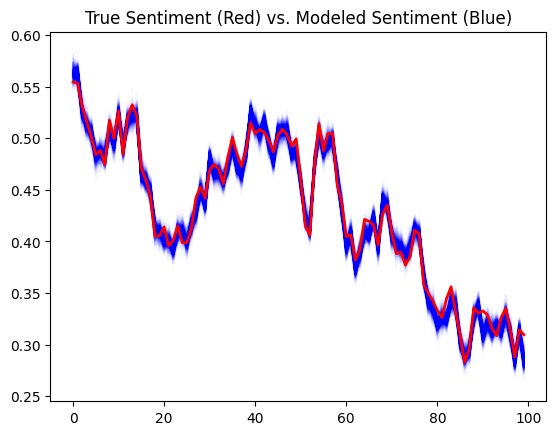

In [10]:
import matplotlib.pyplot as plt

for k in range(1,1000):
    plt.plot(samples3[-k]['p']+samples3[-k]['s'], 'b', alpha=.01)

plt.plot(true_sentiment, linewidth=2, color='r')
plt.title('True Sentiment (Red) vs. Modeled Sentiment (Blue)')


In [ ]:
pm.traceplot(samples3[-1000:], var_names=['margin_of_error'])
